In [72]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from urllib.parse import urlparse
import scipy.stats
%matplotlib inline
cwd = os.getcwd()#To access the path of current working directory
path=cwd+"/"+"data"+"/"

In [73]:
data=pd.read_csv(path +"sample_100k.csv")
data.head()
df=data
df.head()


,url,malicious
0,http://www.facebook-log1in.com/,1
1,http://getir.net/yg4t,1
2,http://crosscitydental.com/,0
3,http://www.tenttrails.com/jscripts/product.js,0
4,http://103.224.193.105/,0


In [74]:
#2016's top most suspicious TLD and words
Suspicious_TLD=['zip','cricket','link','work','party','gq','kim','country','science','tk']
Suspicious_Domain=['luckytime.co.kr','mattfoll.eu.interia.pl','trafficholder.com','dl.baixaki.com.br','bembed.redtube.comr','tags.expo9.exponential.com','deepspacer.com','funad.co.kr','trafficconverter.biz']
delim=['-','.','_','~',':','/','?','#','[',']','@','!','$','&,''','(',')','*','+',',',';','=','`','.']
#trend micro's top malicious domains

## Implementing methods to generate Lexical Features 

In [75]:
# Method to count number of dots
def countdots(url):  
    return url.count('.')
# Method to count number of delimeters
def countdelim(url):
    count = 0
    delim=[';','_','?','=','&']
    for each in url:
        if each in delim:
            count = count + 1
    
    return count
# Is IP addr present as th hostname, let's validate

import ipaddress as ip #works only in python 3

def isip(uri):
    try:
        if ip.ip_address(uri):
            return 1
    except:
        return 0
#method to check the presence of hyphens

def isPresentHyphen(url):
    return url.count('-')
#method to check the presence of @

def isPresentAt(url):
    return url.count('@')
#method to check the presence of DoubleSlash
def isPresentDSlash(url):
    return url.count('//')
#method to count subdirectories 
def countSubDir(url):
    return url.count('/')

def get_ext(url):
    """Return the filename extension from url, or ''."""
    
    root, ext = splitext(url)
    return ext
#method to count subdomains 
def countSubDomain(subdomain):
    if not subdomain:
        return 0
    else:
        return len(subdomain.split('.'))
#method to count queries   
def countQueries(query):
    if not query:
        return 0
    else:
        return len(query.split('&'))
    
#method to count special_chars   
def special_chars(url):
    count=0
    for i in url:
        if not i.isalnum():
                count=count+1
    return count
  
#method to calculate ratio of special_chars  
def ratio_special_chars(url):
    count=special_chars(url)
    return float(count)/float(len(url))



In [76]:
def subDomain(url):
        'check if Ternary'
        isMultipleDomains = '0'
        try:
            hostStart = url.index("//")
            hostEnd = url.index("/", hostStart + 2)
        except:
            hostEnd = len(url)
        host = url[hostStart + 2:hostEnd]
        #including www., if the dots are greater than 3, then High!
        count = str(host).count('.')
        if count < 3:
            isMultipleDomains = '0'
        elif count == 3:
            isMultipleDomains = '1'
        else:
            isMultipleDomains = '2'

        return isMultipleDomains

def topLevelDomainCount(url):
        'counts the occurences of top level domains by matching regular expressions'
        topLevelDomain = '0'
        try:
            hostStart = url.index("//")
            hostEnd = url.index("/", hostStart + 2)
        except:
            hostEnd = len(url)

        path = url[hostEnd+1:]
        m = re.compile(r'\.([^.\n\s]*)$', re.M)
        f = re.findall(m, path)
        if len(f) > 0:
            topLevelDomain = '1'

        return topLevelDomain

def suspicousWords(url):
        'Counts certain suspicious words....'
        haveSuspicious = '0'
        suspicousDatabase = ["confirm","account","secure","viagra","webscr","login","signin","submit","update","logon","wp","cmd","admin","condom"]
        count=0
        for everySuspiciousKeyword in suspicousDatabase:
            if everySuspiciousKeyword in url:
                count+=1
        if count>1:
            haveSuspicious = '1'
        return haveSuspicious

def isLongURL(url):
        'Consult for Ternary Values'
        isLongURL = '0'
        if len(url) < 54:
            isLongURL = '0'
        elif len(url) >= 54 and len(url) <=75:
            isLongURL = '1'
        else:
            isLongURL = '2'
        return isLongURL
    
def digitsInDomain(url):
        isDigits = 0
        try:
            hostStart = url.index("//")
            hostEnd = url.index("/", hostStart + 2)
        except:
            hostEnd = len(url)
        try:
            host = url[hostStart + 2:hostEnd]
            numbers = re.search(r'\d+', host).group()
        except:
            #no numbers found
            numbers = '0'
            isDigits = 0

        if numbers > '0':
            isDigits = 1
        return isDigits

def getCharacterFrequency(url):
        import collections
        freq = collections.Counter(url)
        freqSorted = sorted(freq.items())
        freqList = []
        for i in range(0, 26):
            freqList.append(0)
        for key, value in freqSorted:
            if key.isalpha():
                #check for
                freqList[ord(key.lower()) - 97] = int(value)
                
        return freqList

def getEntropy(url):
        freqList = getCharacterFrequency(url)
        entropy = scipy.stats.entropy(freqList)
        return entropy

def getKLDivergence(url):
        freqEnglish = [8.12, 1.49, 2.71, 4.32, 12.02, 2.30, 2.03, 5.92, 7.31, 0.10, 0.69, 3.98, 2.61, 6.95, 7.68, 1.82, 0.11,
             6.02, 6.28, 9.10, 2.98, 1.11, 2.09, 0.17, 2.11, 0.07]
        freqList = getCharacterFrequency(url)
        kld = scipy.stats.entropy(freqList,freqEnglish)
        return kld

In [77]:
featureExtract = pd.DataFrame(columns=('url','DotsInUrl','countdelim','DotsInSubdomain','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','No of special_chars','ratio_special_chars','validateIPAddress','subDomain','topLevelDomainCount','suspicousWords',\
 'getCharacterFrequency','digitsInDomain','getEntropy','getKLDivergence' ,'label'))


In [78]:
#featureExtract = pd.DataFrame(columns=('url','DotsInUrl','countdelim','DotsInSubdomain','Presence_Of_hyphen','URLLength','Presence_Of_AT',\
#'Presence_Of_double_slash','No_Of_Subdir','No_Of_SubDomain','DomainLength','No_Of_Queries','isIP','Presence_Of_Suspicious_TLD',\
#'Presence_Of_Suspicious_Domain','No_Of_special_chars','ratio_special_chars','isMultipleDomains','topLevelDomainCount','suspicousWords',\
# 'digitsInDomain','isLongURL','getEntropy','getKLDivergence' ,'label'))


In [79]:
from urllib.parse import urlparse
import tldextract
def getFeaturesLexical(url, label): 
    result = []
    url = str(url)
    
    #add the url to feature set
    result.append(url)
    
    #parse the URL and extract the domain information
    path = urlparse(url)
    ext = tldextract.extract(url)
    #counting number of dots
    result.append(countdots(url))
    #counting number of delim
    result.append(countdelim(url))
    #counting number of dots in subdomain    
    result.append(countdots(ext.subdomain))
    
    #checking hyphen in domain   
    result.append(isPresentHyphen(path.netloc))
    
    #length of URL    
    result.append(len(url))
    
    #checking @ in the url    
    result.append(isPresentAt(path.netloc))
    
    #checking presence of double slash    
    result.append(isPresentDSlash(path.path))
    
    #Count number of subdir    
    result.append(countSubDir(path.path))
    
    #number of sub domain    
    result.append(countSubDomain(ext.subdomain))
    
    #length of domain name    
    result.append(len(path.netloc))
    
    #count number of queries    
    result.append(len(path.query))
    
    #Adding domain information
    
    #if IP address is being used as a URL     
    result.append(isip(ext.domain))
    
    #presence of Suspicious_TLD
    result.append(1 if ext.suffix in Suspicious_TLD else 0)
    
    #presence of suspicious domain
    result.append(1 if '.'.join(ext[1:]) in Suspicious_Domain else 0 )
    
    #Number of special characters in URL
    result.append(special_chars(url))
    
    #ratio of special characters in URL
    result.append(ratio_special_chars(url))
    
    #subDomain
    result.append(subDomain(url))
     
    #TopLevelDomain
    result.append(topLevelDomainCount(url))
    
    #Suspicious words
    result.append(suspicousWords(url))
    
    #Digits in Domain
    result.append(digitsInDomain(url))
    
    #IsLongURL
    result.append(isLongURL(url))
    
    #Character Frequency
    result.append(getCharacterFrequency(url))
    
    #Entropy
    result.append(getEntropy(url))
    
    #KL divergence
    result.append(getKLDivergence(url))
    
        
    result.append(str(label))
    return result

In [80]:
def getFeaturesLexicalTest(url, label): 
    result = []
    url = str(url)
    
    #add the url to feature set
    result.append(url)
    
    #parse the URL and extract the domain information
    path = urlparse(url)
    ext = tldextract.extract(url)
    #counting number of dots
    result.append(countdots(url))
    #counting number of delim
    result.append(countdelim(url))
    #counting number of dots in subdomain    
    result.append(countdots(ext.subdomain))
    
    #checking hyphen in domain   
    result.append(isPresentHyphen(path.netloc))
    
    #length of URL    
    result.append(len(url))
    
    #checking @ in the url    
    result.append(isPresentAt(path.netloc))
    
    #checking presence of double slash    
    result.append(isPresentDSlash(path.path))
    
    #Count number of subdir    
    result.append(countSubDir(path.path))
    
    #number of sub domain    
    result.append(countSubDomain(ext.subdomain))
    
    #length of domain name    
    result.append(len(path.netloc))
    
    #count number of queries    
    result.append(len(path.query))
    
    #Adding domain information
    
    #if IP address is being used as a URL     
   # result.append(isip(ext.domain))
    
    #presence of Suspicious_TLD
    result.append(1 if ext.suffix in Suspicious_TLD else 0)
    
    #presence of suspicious domain
    result.append(1 if '.'.join(ext[1:]) in Suspicious_Domain else 0 )
    
    #Number of special characters in URL
    result.append(special_chars(url))
    
    #ratio of special characters in URL
    result.append(ratio_special_chars(url))
    
    #subDomain
    result.append(subDomain(url))
     
    #TopLevelDomain
    result.append(topLevelDomainCount(url))
    
    #Suspicious words
    result.append(suspicousWords(url))
    
    #Digits in Domain
    result.append(digitsInDomain(url))
    
    #IsLongURL
    result.append(isLongURL(url))
    
    #Character Frequency
    result.append(getCharacterFrequency(url))
    
    #Entropy
    result.append(getEntropy(url))
    
    #KL divergence
    result.append(getKLDivergence(url))
    
        
    result.append(str(label))
    return result

### Creating a Dataframe with all the features.

In [81]:
for i in range(len(df)):
    features = getFeaturesLexical(df["url"].loc[i], df["malicious"].loc[i])    
    featureExtract.loc[i] = features

IndexError: list assignment index out of range

In [61]:
featureExtract.head()

,url,DotsInUrl,countdelim,DotsInSubdomain,presence of hyphen,len of url,presence of at,presence of double slash,no of subdir,no of subdomain,...,ratio_special_chars,validateIPAddress,subDomain,topLevelDomainCount,suspicousWords,getCharacterFrequency,digitsInDomain,getEntropy,getKLDivergence,label
0,http://www.facebook-log1in.com/,2,0,0,1,31,0,0,1,1,...,0.225806,0,0,0,1,0,"[1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 4, ...",2.630555,0.602829,1
1,http://getir.net/yg4t,1,0,0,0,21,0,0,1,0,...,0.238095,0,0,0,0,0,"[0, 0, 0, 0, 2, 0, 2, 1, 1, 0, 0, 0, 0, 1, 0, ...",1.986732,0.867503,1
2,http://crosscitydental.com/,1,0,0,0,27,0,0,1,0,...,0.185185,0,0,0,0,0,"[1, 0, 3, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 2, ...",2.563151,0.369844,0
3,http://www.tenttrails.com/jscripts/product.js,3,0,0,0,45,0,0,2,1,...,0.177778,0,1,0,0,0,"[1, 0, 3, 1, 1, 0, 0, 1, 2, 2, 0, 1, 1, 1, 2, ...",2.624194,0.580907,0
4,http://103.224.193.105/,3,0,0,0,23,0,0,1,0,...,0.304348,1,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1.039721,1.867919,0


### Analyze features to identify the dataTypes and look for any null values

In [60]:
featureExtract.isnull().sum()


url                              0
DotsInUrl                        0
countdelim                       0
DotsInSubdomain                  0
presence of hyphen               0
len of url                       0
presence of at                   0
presence of double slash         0
no of subdir                     0
no of subdomain                  0
len of domain                    0
no of queries                    0
is IP                            0
presence of Suspicious_TLD       0
presence of suspicious domain    0
No of special_chars              0
ratio_special_chars              0
validateIPAddress                0
subDomain                        0
topLevelDomainCount              0
suspicousWords                   0
getCharacterFrequency            0
digitsInDomain                   0
getEntropy                       0
getKLDivergence                  0
label                            0
dtype: int64

In [13]:
## convert the object columns to Integer type
featureExtract['DotsInUrl']=featureExtract.DotsInUrl.astype(int)
featureExtract['countdelim']=featureExtract.countdelim.astype(int)
featureExtract['DotsInSubdomain']=featureExtract.DotsInSubdomain.astype(int)
featureExtract['Presence_Of_hyphen']=featureExtract.Presence_Of_hyphen.astype(int)
featureExtract['URLLength']=featureExtract.URLLength.astype(int)
featureExtract['Presence_Of_AT']=featureExtract.Presence_Of_AT.astype(int)
featureExtract['Presence_Of_double_slash']=featureExtract.Presence_Of_double_slash.astype(int)
featureExtract['No_Of_Subdir']=featureExtract.No_Of_Subdir.astype(int)
featureExtract['isIP']=featureExtract.No_Of_Subdir.astype(int)
featureExtract['No_Of_SubDomain']=featureExtract.No_Of_SubDomain.astype(int)
featureExtract['DomainLength']=featureExtract.DomainLength.astype(int)
featureExtract['No_Of_Queries']=featureExtract.No_Of_Queries.astype(int)
featureExtract['No_Of_special_chars']=featureExtract.No_Of_special_chars.astype(int)
featureExtract['isMultipleDomains']=featureExtract.isMultipleDomains.astype(int)
featureExtract['topLevelDomainCount']=featureExtract.topLevelDomainCount.astype(int)
featureExtract['suspicousWords']=featureExtract.suspicousWords.astype(int)
featureExtract['digitsInDomain']=featureExtract.digitsInDomain.astype(int)
featureExtract['isLongURL']=featureExtract.isLongURL.astype(int)
featureExtract['Presence_Of_Suspicious_TLD']=featureExtract.Presence_Of_Suspicious_TLD.astype(int)
featureExtract['Presence_Of_Suspicious_Domain']=featureExtract.Presence_Of_Suspicious_Domain.astype(int)
featureExtract['label']=featureExtract.label.astype(int)  

In [14]:
## export the features to CSV
len(featureExtract)
featureExtract.to_csv(path+ "output.csv")

### Host and Domain Feature Generation

#### Connect to AWS instance of My SQL Database

In [15]:
import pymysql
pymysql.install_as_MySQLdb()

db = pymysql.connect(host="urlwhois.cfug8tk0icxc.us-east-2.rds.amazonaws.com",    # My AWS Hostname
                     user="urlwhois_master",         #  username
                     passwd="urlwhois_master",  #  password
                     db="urlwhois_db1")        # name of the data base

# you must create a Cursor object. It will let
#  you execute all the queries you need
#cur = db.cursor()

# Use all the SQL you like
#cur.execute("SELECT  d.nameserver_count, d.whois_creation_date, d.whois_expiration_date, u.url  from url_domain d , url_info u where d.domain_id=u.url_domain_fk")

# print all the first cell of all the rows
#for row in cur.fetchall():
#   print(row)

#db.close()

In [16]:
db_connection =  pymysql.connect(host="urlwhois.cfug8tk0icxc.us-east-2.rds.amazonaws.com",    # My AWS Hostname
                     user="urlwhois_master",         #  username
                     passwd="urlwhois_master",  #  password
                     db="urlwhois_db1") 
whoisDF=pd.read_sql('SELECT d.nameserver_count, u.url  from url_domain d , url_info u where d.domain_id=u.url_domain_fk', con=db_connection)
FinalWhois=whoisDF.fillna(0)
FinalWhois.head()

,nameserver_count,url
0,2.0,http://www.facebook-log1in.com/
1,2.0,http://getir.net/yg4t
2,2.0,http://crosscitydental.com/
3,2.0,http://www.tenttrails.com/jscripts/product.js
4,0.0,http://103.224.193.105/


In [17]:
rcDF=pd.read_sql('SELECT url_redirect_count, url FROM urlwhois_db1.url_info ', con=db_connection)
finalRC=rcDF.fillna(0)
finalRC.tail()

,url_redirect_count,url
9994,0,http://www.scottishindexes.com/WebResource.axd...
9995,0,http://pmmedios.com/
9996,0,http://apgstudio.pl/pub/rqu/
9997,0,http://www.scg84.de//++theme++barceloneta/less...
9998,1,http://www.collegecodeofconduct.com/live.com/A...


In [18]:
hostFeatures=pd.merge(FinalWhois, finalRC, how='outer', on='url')

hostFeatures.info()
hostFeatures.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9998
Data columns (total 3 columns):
nameserver_count      9999 non-null float64
url                   9999 non-null object
url_redirect_count    9999 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 312.5+ KB


nameserver_count      0
url                   0
url_redirect_count    0
dtype: int64

In [19]:
hostFeatures.tail()

,nameserver_count,url,url_redirect_count
9994,2.0,http://www.scottishindexes.com/WebResource.axd...,0
9995,2.0,http://pmmedios.com/,0
9996,0.0,http://apgstudio.pl/pub/rqu/,0
9997,0.0,http://www.scg84.de//++theme++barceloneta/less...,0
9998,2.0,http://www.collegecodeofconduct.com/live.com/A...,1


### Combine Lexical, Host and Domain Features into one dataframe

In [20]:
allFeatures=pd.merge(hostFeatures, featureExtract, how='inner', on='url')
allFeatures.head()


,nameserver_count,url,url_redirect_count,DotsInUrl,countdelim,DotsInSubdomain,Presence_Of_hyphen,URLLength,Presence_Of_AT,Presence_Of_double_slash,...,No_Of_special_chars,ratio_special_chars,isMultipleDomains,topLevelDomainCount,suspicousWords,digitsInDomain,isLongURL,getEntropy,getKLDivergence,label
0,2.0,http://www.facebook-log1in.com/,0,2,0,0,1,31,0,0,...,7,0.225806,0,0,0,1,0,2.630555,0.602829,1
1,2.0,http://getir.net/yg4t,0,1,0,0,0,21,0,0,...,5,0.238095,0,0,0,0,0,1.986732,0.867503,1
2,2.0,http://crosscitydental.com/,0,1,0,0,0,27,0,0,...,5,0.185185,0,0,0,0,0,2.563151,0.369844,0
3,2.0,http://www.tenttrails.com/jscripts/product.js,0,3,0,0,0,45,0,0,...,8,0.177778,0,1,0,0,0,2.624194,0.580907,0
4,0.0,http://103.224.193.105/,0,3,0,0,0,23,0,0,...,7,0.304348,1,0,0,1,0,1.039721,1.867919,0


In [21]:
allFeatures.to_csv(path+ "output2.csv")


In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle as pkl
from __future__ import division

#### Plot the Distribution of some features with Malicious and Beinign URL to understand the distribution and ooverlap

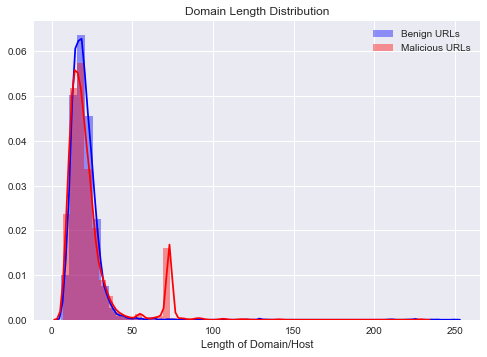

In [23]:

sns.set(style="darkgrid")
sns.distplot(featureExtract[featureExtract['label']==0]['DomainLength'],color='blue',label='Benign URLs')
sns.distplot(featureExtract[featureExtract['label']==1]['DomainLength'],color='red',label='Malicious URLs')
sns.plt.title('Domain Length Distribution')
plt.legend(loc='upper right')
plt.xlabel('Length of Domain/Host')
sns.plt.show()


#### Domain Length for malicious URL is higher in most cases in comparison to the domain length for benign URL's

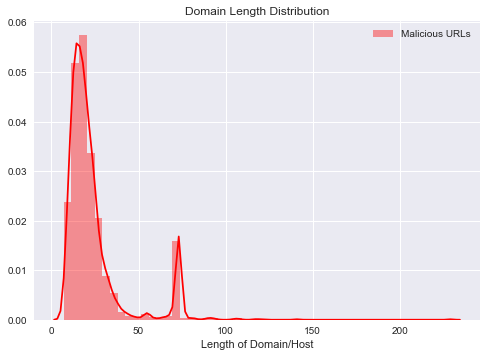

In [23]:
sns.set(style="darkgrid")
sns.distplot(featureExtract[featureExtract['label']==1]['DomainLength'],color='red',label='Malicious URLs')
sns.plt.title('Domain Length Distribution')
plt.legend(loc='upper right')
plt.xlabel('Length of Domain/Host')
sns.plt.show()


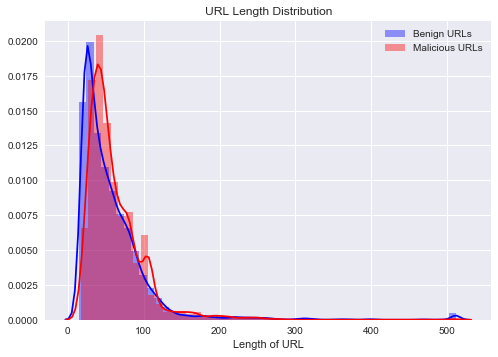

In [26]:

sns.set(style="darkgrid")
sns.distplot(featureExtract[featureExtract['label']==0]['URLLength'],color='blue',label='Benign URLs')
sns.distplot(featureExtract[featureExtract['label']==1]['URLLength'],color='red',label='Malicious URLs')
sns.plt.title('URL Length Distribution')
plt.legend(loc='upper right')
plt.xlabel('Length of URL')
sns.plt.show()

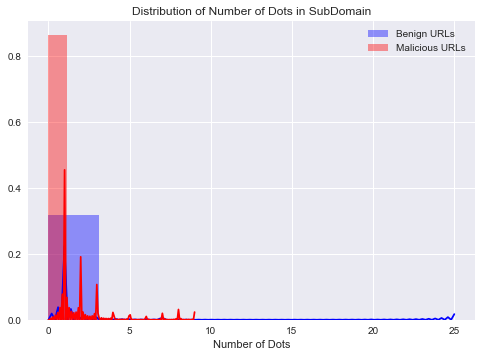

In [27]:
x=featureExtract[featureExtract['label']==0]['DotsInSubdomain']
y=featureExtract[featureExtract['label']==1]['DotsInSubdomain']
#plt.hist(x,bins=8, alpha=0.9, label='Benign URLs',color='blue')
sns.distplot(x,bins=8,color='blue',label='Benign URLs')
#plt.hist(y,bins=10, alpha=0.6, label='Malicious URLs',color='red')
sns.distplot(y,bins=8,color='red',label='Malicious URLs')
plt.legend(loc='upper right')
plt.xlabel('Number of Dots')
plt.title('Distribution of Number of Dots in SubDomain')
plt.show()


#### Number of dots in subdomain malicious URL is higher in most cases in comparison to  benign URL's

<module 'matplotlib.pyplot' from '/Applications/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

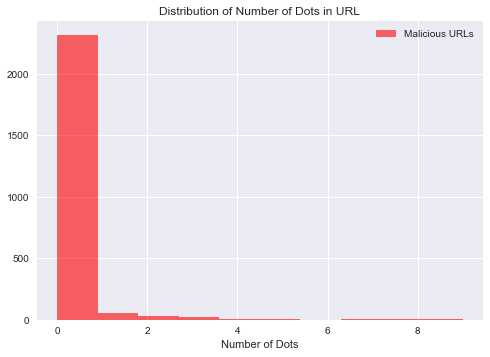

In [25]:
x=featureExtract[featureExtract['label']==0]['DotsInSubdomain']
y=featureExtract[featureExtract['label']==1]['DotsInSubdomain']
#plt.hist(x,bins=8, alpha=0.9, label='Benign URLs',color='blue')
#sns.distplot(x,bins=8,color='blue',label='Benign URLs')
plt.hist(y,bins=10, alpha=0.6, label='Malicious URLs',color='red')
#sns.distplot(y,bins=8,color='red',label='Malicious URLs')
plt.legend(loc='upper right')
plt.xlabel('Number of Dots')
plt.title('Distribution of Number of Dots in URL')
plt

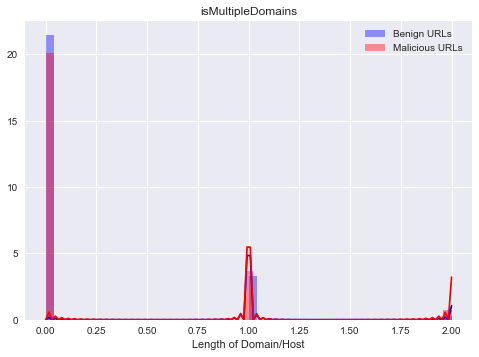

In [26]:
sns.set(style="darkgrid")
sns.distplot(featureExtract[featureExtract['label']==0]['isMultipleDomains'],color='blue',label='Benign URLs')
sns.distplot(featureExtract[featureExtract['label']==1]['isMultipleDomains'],color='red',label='Malicious URLs')
sns.plt.title('isMultipleDomains')
plt.legend(loc='upper right')
plt.xlabel('Length of Domain/Host')
sns.plt.show()

#### Presence of multiple subdomians for malicious URL is higher in most cases in comparison to that of benign URL's

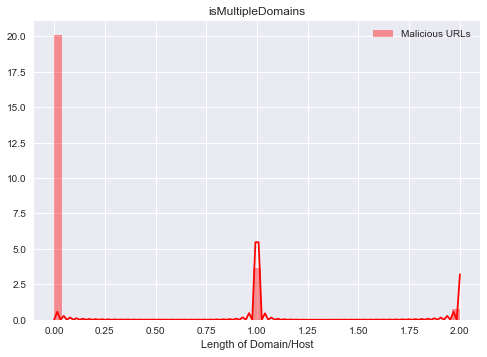

In [27]:
sns.set(style="darkgrid")
sns.distplot(featureExtract[featureExtract['label']==1]['isMultipleDomains'],color='red',label='Malicious URLs')
sns.plt.title('isMultipleDomains')
plt.legend(loc='upper right')
plt.xlabel('Length of Domain/Host')
sns.plt.show()

#### Comparing Entropy and KL-Divergence   for malicious URL and benign URL's also shows these cna be useful features to train the model


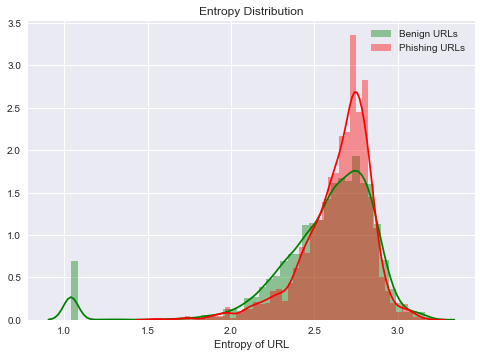

In [28]:
sns.set(style="darkgrid")
sns.distplot(featureExtract[featureExtract['label']==0]['getEntropy'],color='green',label='Benign URLs')
sns.distplot(featureExtract[featureExtract['label']==1]['getEntropy'],color='red',label='Phishing URLs')
sns.plt.title('Entropy Distribution')
plt.legend(loc='upper right')
plt.xlabel('Entropy of URL')

sns.plt.show()

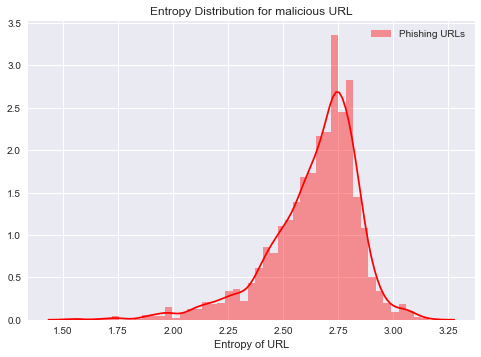

In [29]:
sns.set(style="darkgrid")
#sns.distplot(featureExtract[featureExtract['label']=='0']['getEntropy'],color='green',label='Benign URLs')
sns.distplot(featureExtract[featureExtract['label']==1]['getEntropy'],color='red',label='Phishing URLs')
sns.plt.title('Entropy Distribution for malicious URL')
plt.legend(loc='upper right')
plt.xlabel('Entropy of URL')

sns.plt.show()

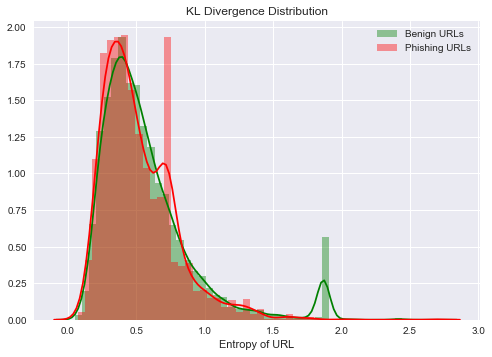

In [30]:
sns.set(style="darkgrid")
sns.distplot(featureExtract[featureExtract['label']==0]['getKLDivergence'],color='green',label='Benign URLs')
sns.distplot(featureExtract[featureExtract['label']==1]['getKLDivergence'],color='red',label='Phishing URLs')
sns.plt.title('KL Divergence Distribution')
plt.legend(loc='upper right')
plt.xlabel('Entropy of URL')

sns.plt.show()

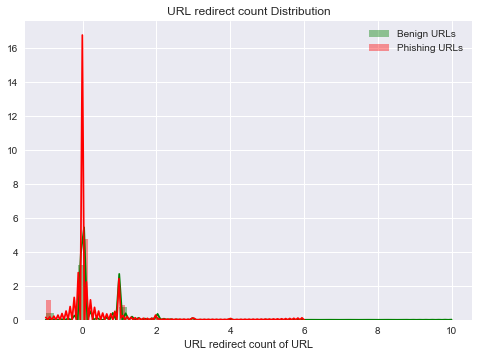

In [29]:
sns.set(style="darkgrid")
sns.distplot(allFeatures[allFeatures['label']==0]['url_redirect_count'],color='green',label='Benign URLs')
sns.distplot(allFeatures[allFeatures['label']==1]['url_redirect_count'],color='red',label='Phishing URLs')
sns.plt.title('URL redirect count Distribution')
plt.legend(loc='upper right')
plt.xlabel('URL redirect count of URL')

sns.plt.show()

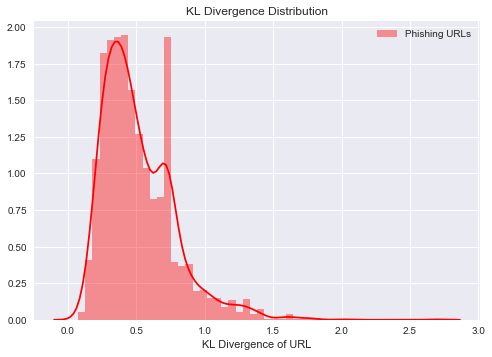

In [31]:
sns.set(style="darkgrid")
#sns.distplot(featureExtract[featureExtract['label']=='0']['getKLDivergence'],color='green',label='Benign URLs')
sns.distplot(featureExtract[featureExtract['label']==1]['getKLDivergence'],color='red',label='Phishing URLs')
sns.plt.title('KL Divergence Distribution')
plt.legend(loc='upper right')
plt.xlabel('KL Divergence of URL')

sns.plt.show()

### Use all the feautres generated above to train the classifiers and also determine the accuracy

In [57]:
import sklearn.ensemble as ek
from sklearn import cross_validation, tree, linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB, MultinomialNB,BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import metrics

In [58]:
X = allFeatures.drop(['url','label'],axis=1).values
y = allFeatures['label'].values

In [59]:
model = { "DecisionTree":tree.DecisionTreeClassifier(max_depth=10),
         "RandomForest":ek.RandomForestClassifier(n_estimators=100,random_state=42),
        "GNB":GaussianNB(),
         "LogisticRegression":LogisticRegression()   
}

In [60]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y ,test_size=0.2,random_state=10)


In [61]:
results = {}
for algo in model:
    clf = model[algo]
    clf.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print ("%s : %s " %(algo, score))
    results[algo] = score

DecisionTree : 0.822734101152 
RandomForest : 0.844266399599 
GNB : 0.544817225839 
LogisticRegression : 0.807210816224 


In [62]:
resultsFP = {}
for algo in model:
    print ("%s " %(algo))
    clf = model[algo]
    res = clf.predict(X)
    mt = confusion_matrix(y, res)
    #print(mt)
    print("False positive rate : %f %%" % ((mt[0][1] / float(sum(mt[0])))*100))
    print('False negative rate : %f %%' % ( (mt[1][0] / float(sum(mt[1]))*100)))
    

DecisionTree 
False positive rate : 3.774834 %
False negative rate : 44.266338 %
RandomForest 
False positive rate : 0.953642 %
False negative rate : 9.823263 %
GNB 
False positive rate : 52.556291 %
False negative rate : 19.317715 %
LogisticRegression 
False positive rate : 3.536424 %
False negative rate : 67.488697 %


In [63]:
resultsFP = {}
for algo in model:
    print ("%s " %(algo))
    clf = model[algo]
    res = clf.predict(X_test)
  #  mt = confusion_matrix(y, res)
    #print(mt)
    #y_pred = NBm.predict(X_test)
    print("F-1 score for  the model: %f %%" % ((f1_score(y_test, res, average="macro"))*100))
    print("Precision score for  the model: %f %%" % ((precision_score(y_test, res, average="macro"))*100))
    print("Recall  score for  the model: %f %%" %((recall_score(y_test, res, average="macro"))*100)) 

DecisionTree 
F-1 score for  the model: 72.689491 %
Precision score for  the model: 78.066301 %
Recall  score for  the model: 70.285340 %
RandomForest 
F-1 score for  the model: 76.158958 %
Precision score for  the model: 81.835137 %
Recall  score for  the model: 73.414507 %
GNB 
F-1 score for  the model: 53.528571 %
Precision score for  the model: 60.513400 %
Recall  score for  the model: 63.441336 %
LogisticRegression 
F-1 score for  the model: 67.419517 %
Precision score for  the model: 77.795366 %
Recall  score for  the model: 65.041307 %


## Generated a boxplot to understand the distribution across multiple features. 

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  This is separate from the ipykernel package so we can avoid doing imports until


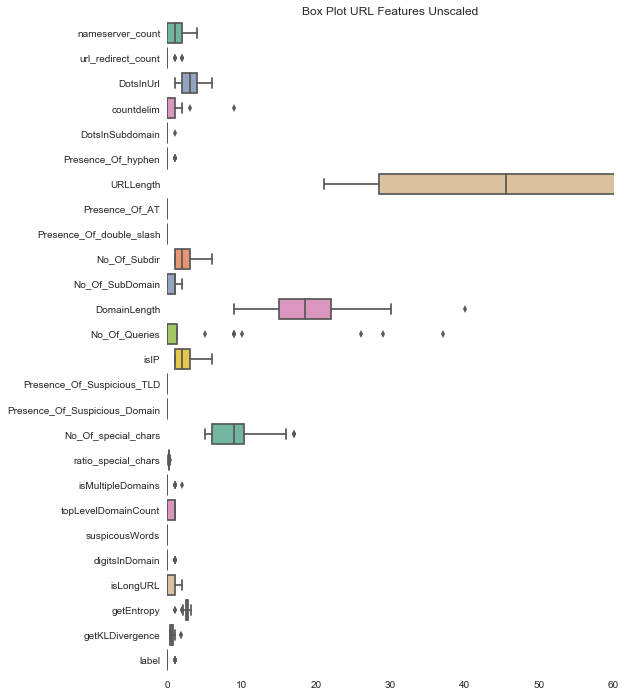

In [64]:
f, ax = plt.subplots(figsize=(8, 12))

ax.set_axis_bgcolor('#FFFFFF')
plt.title("Box Plot URL Features Unscaled")
ax.set(xlim=(0, 60))
ax = sns.boxplot(data = allFeatures[0:40], 
  orient = 'h', 
  palette = 'Set2')

###  Created a sample function to help scale the data. 

In [65]:
def scaled_df(allFeatures):
    scaled = pd.DataFrame()
    for item in allFeatures:
        if item in allFeatures.select_dtypes(include=[np.int64, np.float64]):
            scaled[item] = ((allFeatures[item] - allFeatures[item].min()) / 
            (allFeatures[item].max() - allFeatures[item].min()))
        else: 
            scaled[item] = allFeatures[item]
    return scaled
allFeatures_scaled = scaled_df(allFeatures)
allFeatures_scaled=allFeatures_scaled.fillna(0)

In [66]:
allFeatures_scaled.head()

,nameserver_count,url,url_redirect_count,DotsInUrl,countdelim,DotsInSubdomain,Presence_Of_hyphen,URLLength,Presence_Of_AT,Presence_Of_double_slash,...,No_Of_special_chars,ratio_special_chars,isMultipleDomains,topLevelDomainCount,suspicousWords,digitsInDomain,isLongURL,getEntropy,getKLDivergence,label
0,0.153846,http://www.facebook-log1in.com/,0.090909,0.022727,0.0,0.0,0.0625,0.034137,0.0,0.0,...,0.01250,0.546814,0.0,0.0,0.0,1.0,0.0,0.734728,0.208089,1.0
1,0.153846,http://getir.net/yg4t,0.090909,0.000000,0.0,0.0,0.0000,0.014056,0.0,0.0,...,0.00000,0.578784,0.0,0.0,0.0,0.0,0.0,0.437378,0.307745,1.0
2,0.153846,http://crosscitydental.com/,0.090909,0.000000,0.0,0.0,0.0000,0.026104,0.0,0.0,...,0.00000,0.441132,0.0,0.0,0.0,0.0,0.0,0.703598,0.120364,0.0
3,0.153846,http://www.tenttrails.com/jscripts/product.js,0.090909,0.045455,0.0,0.0,0.0000,0.062249,0.0,0.0,...,0.01875,0.421861,0.0,1.0,0.0,0.0,0.0,0.731790,0.199834,0.0
4,0.000000,http://103.224.193.105/,0.090909,0.045455,0.0,0.0,0.0000,0.018072,0.0,0.0,...,0.01250,0.751149,0.5,0.0,0.0,1.0,0.0,0.000000,0.684425,0.0


/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  This is separate from the ipykernel package so we can avoid doing imports until


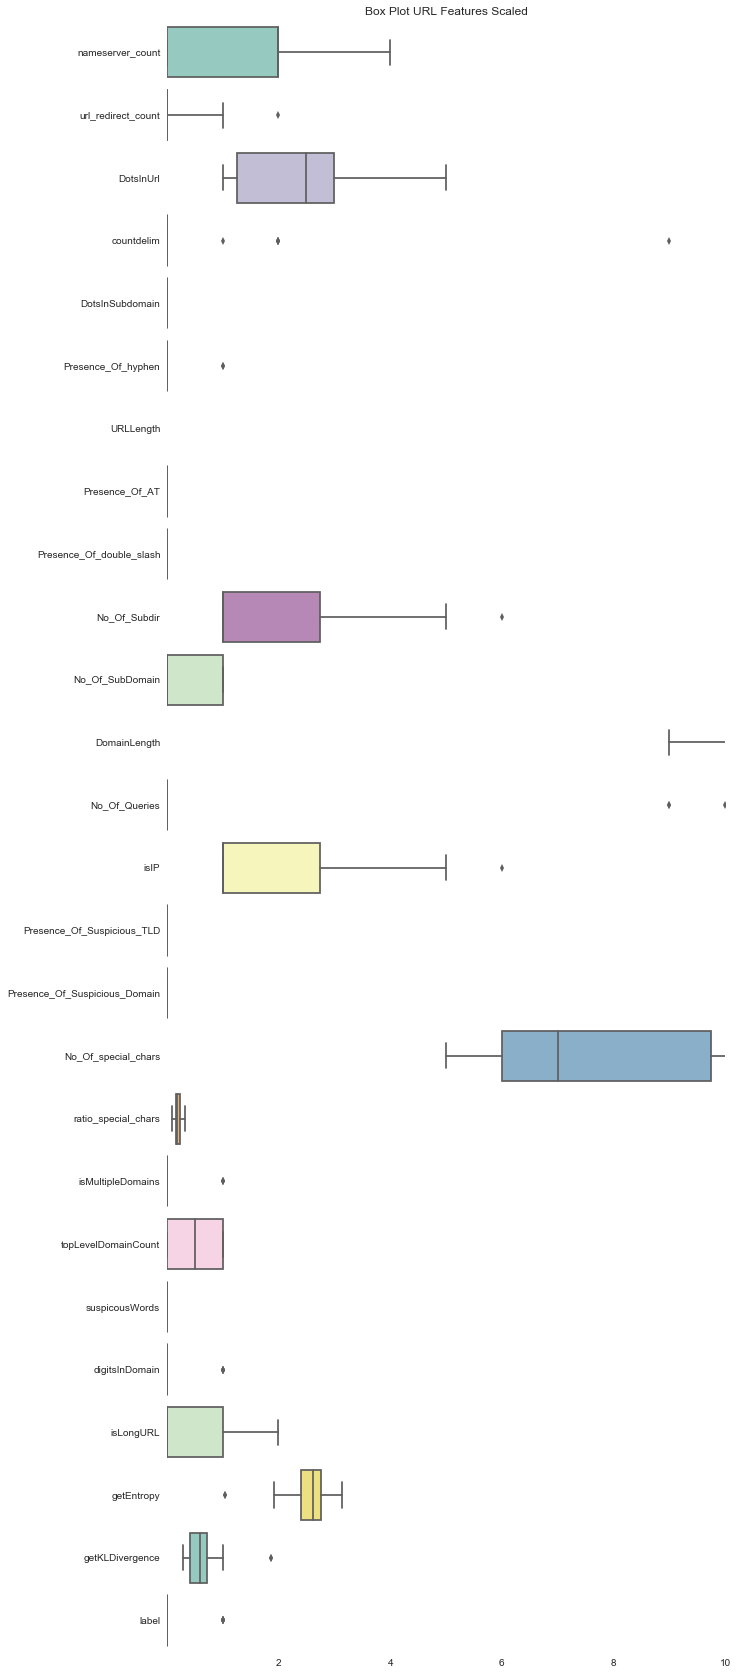

In [67]:
f, ax = plt.subplots(figsize=(10, 30))

ax.set_axis_bgcolor('#FFFFFF')
plt.title("Box Plot URL Features Scaled")
ax.set(xlim=(0.01, 10))
ax = sns.boxplot(data = allFeatures[1:27], 
  orient = 'h', 
  palette = 'Set3')

### Using Random Forest to further evaluate predictors and also created a model to ran the predictors 

In [68]:
RFm = ek.RandomForestClassifier(random_state = 42, 
                                criterion='gini',
                                n_estimators = 500,
                                max_features = 5)

### Dropped the features that generate Non numeric values during median based scaling.

In [69]:
#sns.boxplot(x='label', y='Presence_Of_Suspicious_Domain', data=allFeatures)

In [70]:
X1= allFeatures.drop(['url','label','Presence_Of_AT','Presence_Of_Suspicious_Domain','Presence_Of_Suspicious_TLD',],axis=1)


In [71]:
RFm.fit(X1,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [72]:
### Calculating the info gain for each feature. 
high_info_gain = RFm.feature_importances_
index_ig = np.argsort(high_info_gain)[::-1]
index_ig

array([21, 20, 14, 10,  6, 13,  9, 12,  8,  0,  1,  2,  3, 17, 11,  5, 16,
       18, 19, 15,  4,  7])

In [73]:
temp= allFeatures.drop(['url','label','Presence_Of_AT','Presence_Of_Suspicious_Domain','Presence_Of_Suspicious_TLD'],axis=1)
featuresOnly=allFeatures.drop(['url','Presence_Of_AT','Presence_Of_Suspicious_Domain','Presence_Of_Suspicious_TLD'],axis=1)

predictor_names=temp.columns.tolist()
predictor_names

['nameserver_count',
 'url_redirect_count',
 'DotsInUrl',
 'countdelim',
 'DotsInSubdomain',
 'Presence_Of_hyphen',
 'URLLength',
 'Presence_Of_double_slash',
 'No_Of_Subdir',
 'No_Of_SubDomain',
 'DomainLength',
 'No_Of_Queries',
 'isIP',
 'No_Of_special_chars',
 'ratio_special_chars',
 'isMultipleDomains',
 'topLevelDomainCount',
 'suspicousWords',
 'digitsInDomain',
 'isLongURL',
 'getEntropy',
 'getKLDivergence']

### Generating predictors from features that can impact he Naive Bayes Model Better

In [74]:
def rank_predictors(featuresOnly,l,f='label'):
    rank={}
    max_vals=featuresOnly.max()
    median_vals=featuresOnly.groupby(f).median()  
    for p in l:
        score=np.abs((median_vals[p][0]-median_vals[p][1])/max_vals[p])
        rank[p]=score
    return rank
cat_rank=rank_predictors(featuresOnly,predictor_names) 
cat_rank

{'DomainLength': 0.0,
 'DotsInSubdomain': 0.0,
 'DotsInUrl': 0.0,
 'No_Of_Queries': 0.0,
 'No_Of_SubDomain': 0.038461538461538464,
 'No_Of_Subdir': 0.066666666666666666,
 'No_Of_special_chars': 0.0060606060606060606,
 'Presence_Of_double_slash': 0.0,
 'Presence_Of_hyphen': 0.0,
 'URLLength': 0.01171875,
 'countdelim': 0.0,
 'digitsInDomain': 0.0,
 'getEntropy': 0.017714634839454756,
 'getKLDivergence': 0.012529527643127043,
 'isIP': 0.066666666666666666,
 'isLongURL': 0.0,
 'isMultipleDomains': 0.0,
 'nameserver_count': 0.15384615384615385,
 'ratio_special_chars': 0.045726637845028284,
 'suspicousWords': 0.0,
 'topLevelDomainCount': 1.0,
 'url_redirect_count': 0.0}

In [75]:
cat_rank=sorted(cat_rank.items(), key=lambda x: x[1])
cat_rank

[('url_redirect_count', 0.0),
 ('DotsInUrl', 0.0),
 ('countdelim', 0.0),
 ('DotsInSubdomain', 0.0),
 ('Presence_Of_hyphen', 0.0),
 ('Presence_Of_double_slash', 0.0),
 ('DomainLength', 0.0),
 ('No_Of_Queries', 0.0),
 ('isMultipleDomains', 0.0),
 ('suspicousWords', 0.0),
 ('digitsInDomain', 0.0),
 ('isLongURL', 0.0),
 ('No_Of_special_chars', 0.0060606060606060606),
 ('URLLength', 0.01171875),
 ('getKLDivergence', 0.012529527643127043),
 ('getEntropy', 0.017714634839454756),
 ('No_Of_SubDomain', 0.038461538461538464),
 ('ratio_special_chars', 0.045726637845028284),
 ('No_Of_Subdir', 0.066666666666666666),
 ('isIP', 0.066666666666666666),
 ('nameserver_count', 0.15384615384615385),
 ('topLevelDomainCount', 1.0)]

In [76]:
ranked_predictors=[]
for f in cat_rank[12:]:
    ranked_predictors.append(f[0])
ranked_predictors

['No_Of_special_chars',
 'URLLength',
 'getKLDivergence',
 'getEntropy',
 'No_Of_SubDomain',
 'ratio_special_chars',
 'No_Of_Subdir',
 'isIP',
 'nameserver_count',
 'topLevelDomainCount']

In [77]:
high_info_gain = RFm.feature_importances_
index_ig = np.argsort(high_info_gain)[::-1]
print(index_ig)

print(len(predictor_names))

[21 20 14 10  6 13  9 12  8  0  1  2  3 17 11  5 16 18 19 15  4  7]
22


In [78]:
# Print the feature ranking
print("Feature ranking:")
ranked_predictors_RF=[]
for f in range(len(predictor_names)):
    i = f
    if i < len(ranked_predictors):
        ranked_predictors_RF.append(predictor_names[index_ig[i]])  
    print("%d. The feature '%s' \
    has a Information Gain of %f" % (f + 1,
                predictor_names[index_ig[i]],
                high_info_gain[index_ig[f]]))

Feature ranking:
1. The feature 'getKLDivergence'     has a Information Gain of 0.118397
2. The feature 'getEntropy'     has a Information Gain of 0.116142
3. The feature 'ratio_special_chars'     has a Information Gain of 0.110657
4. The feature 'DomainLength'     has a Information Gain of 0.106932
5. The feature 'URLLength'     has a Information Gain of 0.093771
6. The feature 'No_Of_special_chars'     has a Information Gain of 0.057034
7. The feature 'No_Of_SubDomain'     has a Information Gain of 0.052635
8. The feature 'isIP'     has a Information Gain of 0.043149
9. The feature 'No_Of_Subdir'     has a Information Gain of 0.041936
10. The feature 'nameserver_count'     has a Information Gain of 0.041012
11. The feature 'url_redirect_count'     has a Information Gain of 0.037323
12. The feature 'DotsInUrl'     has a Information Gain of 0.032823
13. The feature 'countdelim'     has a Information Gain of 0.027940
14. The feature 'suspicousWords'     has a Information Gain of 0.02727

In [79]:
print (ranked_predictors)
print (ranked_predictors_RF)

['No_Of_special_chars', 'URLLength', 'getKLDivergence', 'getEntropy', 'No_Of_SubDomain', 'ratio_special_chars', 'No_Of_Subdir', 'isIP', 'nameserver_count', 'topLevelDomainCount']
['getKLDivergence', 'getEntropy', 'ratio_special_chars', 'DomainLength', 'URLLength', 'No_Of_special_chars', 'No_Of_SubDomain', 'isIP', 'No_Of_Subdir', 'nameserver_count']


In [80]:
# Lets combine the Random Forest and median difference rankings.
# Note that they are largely in agreement as only 2 were added to the original list of 12
for p in ranked_predictors_RF:
    if p not in ranked_predictors:
        ranked_predictors.append(p)
print (ranked_predictors)
print (len(ranked_predictors))

['No_Of_special_chars', 'URLLength', 'getKLDivergence', 'getEntropy', 'No_Of_SubDomain', 'ratio_special_chars', 'No_Of_Subdir', 'isIP', 'nameserver_count', 'topLevelDomainCount', 'DomainLength']
11


In [81]:
print (ranked_predictors)
i=['label']
#ranked_predictors
i=i+ranked_predictors
print (i)
featuresOnly_ranked=featuresOnly[i]
# convert diagnosis to a numeric variable to create a numeric dependent variable

featuresOnly_ranked.head()

['No_Of_special_chars', 'URLLength', 'getKLDivergence', 'getEntropy', 'No_Of_SubDomain', 'ratio_special_chars', 'No_Of_Subdir', 'isIP', 'nameserver_count', 'topLevelDomainCount', 'DomainLength']
['label', 'No_Of_special_chars', 'URLLength', 'getKLDivergence', 'getEntropy', 'No_Of_SubDomain', 'ratio_special_chars', 'No_Of_Subdir', 'isIP', 'nameserver_count', 'topLevelDomainCount', 'DomainLength']


,label,No_Of_special_chars,URLLength,getKLDivergence,getEntropy,No_Of_SubDomain,ratio_special_chars,No_Of_Subdir,isIP,nameserver_count,topLevelDomainCount,DomainLength
0,1,7,31,0.602829,2.630555,1,0.225806,1,1,2.0,0,23
1,1,5,21,0.867503,1.986732,0,0.238095,1,1,2.0,0,9
2,0,5,27,0.369844,2.563151,0,0.185185,1,1,2.0,0,19
3,0,8,45,0.580907,2.624194,1,0.177778,2,2,2.0,1,18
4,0,7,23,1.867919,1.039721,0,0.304348,1,1,0.0,0,15


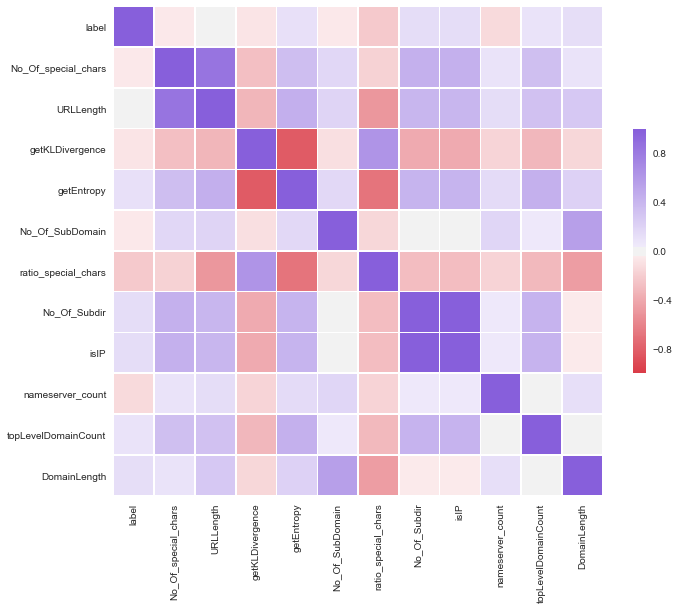

In [82]:
corr = featuresOnly_ranked.corr(method = 'pearson') # Correlation Matrix

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 275, as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap,square=True, 
            xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

label                  1.000000
No_Of_special_chars   -0.047094
URLLength              0.032721
getKLDivergence       -0.074746
getEntropy             0.111303
No_Of_SubDomain       -0.046998
ratio_special_chars   -0.224160
No_Of_Subdir           0.136073
isIP                   0.136073
nameserver_count      -0.130878
topLevelDomainCount    0.097190
DomainLength           0.127677
Name: label, dtype: float64

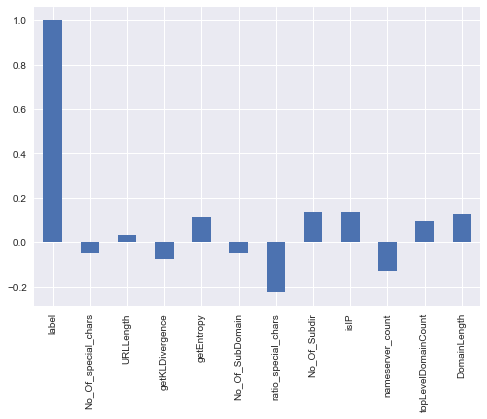

In [83]:
featuresOnly_ranked.corr()["label"].plot(kind="bar")
featuresOnly_ranked.corr()["label"]

In [84]:
from sklearn.cross_validation import KFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score,precision_score,recall_score

In [85]:
X = featuresOnly_ranked[ranked_predictors]
#setting target
y = featuresOnly_ranked["label"]

In [86]:
# setting Naive Bayes classifier
nb = GaussianNB()

#dividing data to have a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .4, random_state=0)

# Naive Bayes cross validation
Kfold = KFold(len(featuresOnly_ranked), n_folds=5, shuffle=False)
print("KfoldCrossVal mean score using Naive Bayes is %s" %cross_val_score(nb,X,y,cv=10).mean())

# Naive Bayes metrics
NBm = nb.fit(X_train, y_train)

y_pred = NBm.predict(X_test)

print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))    
print("Accuracy score using Naive Bayes is %s" %metrics.accuracy_score(y_test, y_pred))

KfoldCrossVal mean score using Naive Bayes is 0.68926942975
0.620850208401
0.617343711312
0.644884078383
Accuracy score using Naive Bayes is 0.681772658988


In [89]:
# setting Naive Bayes classifier
mb = MultinomialNB()

#dividing data to have a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .4, random_state=0)

# Naive Bayes cross validation
Kfold = KFold(len(featuresOnly_ranked), n_folds=5, shuffle=False)
print("KfoldCrossVal mean score using Naive Bayes is %s" %cross_val_score(mb,X,y,cv=10).mean())

# Naive Bayes metrics
NBm = mb.fit(X_train, y_train)

y_pred = NBm.predict(X_test)
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))    
print("Accuracy score using Naive Bayes is %s" %metrics.accuracy_score(y_test, y_pred))

KfoldCrossVal mean score using Naive Bayes is 0.759691454982
0.566433080847
0.652866356019
0.566517814823
Accuracy score using Naive Bayes is 0.758888332499


In [184]:
X = featuresOnly_ranked[ranked_predictors]
#setting target
y = featuresOnly_ranked["label"]

In [130]:
for algo in model:
    print ("%s " %(algo))
    clf = model[algo]
    result =pd.DataFrame(columns=('url','DotsInUrl','countdelim','DotsInSubdomain','Presence_Of_hyphen','URLLength','Presence_Of_AT',\
'Presence_Of_double_slash','No_Of_Subdir','No_Of_SubDomain','DomainLength','No_Of_Queries','Presence_Of_Suspicious_TLD',\
'Presence_Of_Suspicious_Domain','No_Of_special_chars','ratio_special_chars','isMultipleDomains','topLevelDomainCount','suspicousWords',\
 'digitsInDomain','isLongURL','getEntropy','getKLDivergence' ,'label'))
    results = getFeaturesLexicalTest('http://clubdasjoaninhas.com/Sip/Indexxatt.htm', '1')
    result.loc[0] = results
    result['isip']=0
    result['nameserver_count']=2
    result['url_redirect_count']=3
    result = result.drop(['url','label'],axis=1).values
    print(clf.predict(result))

DecisionTree 
[1]
RandomForest 
[1]
GNB 
[1]
LogisticRegression 
[1]


### TF-IDF on the URLS and generating the vectors

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [66]:
def getTokens(input1):
    tokensBySlash = str(input1).split('/')#get tokens after splitting by slash
    allTokens = []
    for i in tokensBySlash:
       
        tokens = str(i).split('-')#get tokens after splitting by dash
        tokensByDot = []
        for j in range(0,len(tokens)):
            tempTokens = str(tokens[j]).split('.')         #get tokens after splitting by dot
            tokensByDot = tokensByDot + tempTokens
        allTokens = allTokens + tokens + tokensByDot
    allTokens = list(set(allTokens))#remove redundant tokens
   
    for extension in ['com','php','js','gif','jpg','png']:
        if extension in allTokens:
            allTokens.remove(extension)
    return allTokens
 


In [152]:
 
##following code is creating a vectorizer from url data.
df=pd.read_csv(path +"sample_500k.csv")
#X_train, X_test, y_train, y_test = train_test_split(data, data["malicious"], test_size=0.1, random_state=42)
vectorizer = TfidfVectorizer(tokenizer=getTokens) #get a vector for each url but use our customized tokenizer
X = vectorizer.fit_transform(df["url"])
y = df["malicious"]

In [146]:
#print(X.data)
#print(X)

In [153]:
lr = LogisticRegression()

#dividing data to have a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .4, random_state=0)

# Logistic regression cross validation
Kfold = KFold(len(ranked_predictors), n_folds=5, shuffle=False)
print("KfoldCrossVal mean score using Logistic regression is %s" %cross_val_score(lr,X,y,cv=10).mean())

# Logistic regression metrics
LRm = lr.fit(X_train, y_train)
print(LRm.score(X_test,y_test))
#LRm.predict_proba(X_test)  # The returned estimates for all classes are ordered by the label of classes

0.906985
